<a href="https://colab.research.google.com/github/pranavmicro7/Convolutional-Autoencoder-for-Noise-Removal-/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Accessing MNIST dataset from Google Drive
!unzip '/content/drive/My Drive/autoencoder noise removal/mnist-in-csv.zip'

Archive:  /content/drive/My Drive/autoencoder noise removal/mnist-in-csv.zip
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         


In [0]:
#Importing Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import shutil
from keras.applications import VGG16
from keras.layers import Dense,Conv2D,UpSampling2D,Input,BatchNormalization,MaxPooling2D
from keras import models,layers,optimizers
from keras.preprocessing.image import ImageDataGenerator
import os

Using TensorFlow backend.


In [0]:
#Reading and convering train and test data to DataFrame
test='/content/mnist_test.csv'
train='/content/mnist_train.csv'

data_train=pd.read_csv(train)
data_test=pd.read_csv(test)

print('Training Data Shape of MNIST : ',np.shape(data_train))
print('Testing Data Shape of MNIST : ',np.shape(data_test))

Training Data Shape of MNIST :  (60000, 785)
Testing Data Shape of MNIST :  (10000, 785)


In [0]:
#Denoising the images and creating train and test dataset for the Autoencoder
#MNIST test dataset is used to train Autoencoder for noise removal
x_test=data_test.iloc[:,1:]

mean = 0
var = 2000
sigma = var ** 0.5
gaussian = np.random.normal(mean, sigma, (64, 64))

autoencoder_x=[]
autoencoder_y=[]

for i in range(len(x_test)):
  img=x_test.iloc[i,:]
  img=np.resize(img,(28,28)).astype(np.uint8)
  img=cv2.resize(img,(64,64))

  autoencoder_y.append(img) 

  
  noisy_image = np.zeros(img.shape, np.float32)
  noisy_image = img + gaussian
  cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
  noisy_image = noisy_image.astype(np.uint8)
  autoencoder_x.append(noisy_image)

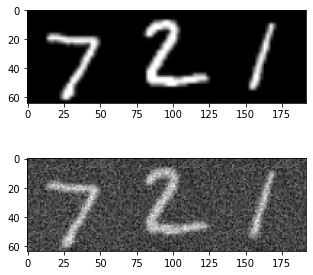

In [0]:
org1=autoencoder_y[0]
noised1=autoencoder_x[0]

org2=autoencoder_y[1]
noised2=autoencoder_x[1]

org3=autoencoder_y[2]
noised3=autoencoder_x[2]

original = np.concatenate((org1, org2, org3), axis=1)
noised = np.concatenate((noised1, noised2, noised3), axis=1)

fig=plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(original,cmap='gray') 
ax2 = fig.add_subplot(2,1,2)
ax2.imshow(noised,cmap='gray') 


In [0]:
#Reshaping the train and test set to feed into autoencoder
autoencoder_x=np.array(autoencoder_x)
autoencoder_y=np.array(autoencoder_y)

autoencoder_x=np.reshape(autoencoder_x,(10000,64,64,1))
autoencoder_y=np.reshape(autoencoder_y,(10000,64,64,1))

print(np.shape(autoencoder_x))
print(np.shape(autoencoder_y))

(10000, 64, 64, 1)
(10000, 64, 64, 1)


In [0]:
#Autoencoder

#Encoder
input_ = Input(shape=(64,64,1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_)
x=BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x=BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x=BatchNormalization()(x)
encoded = MaxPooling2D((2, 2))(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
#x = UpSampling2D((2, 2))(encoded)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x=BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x=BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x=BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

autoencoder = models.Model(input_ ,decoded)
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='Adam') 

history_autoencoder=autoencoder.fit(autoencoder_x,autoencoder_y,batch_size=16,epochs=80, shuffle=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0   

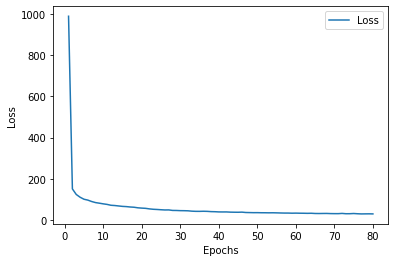

In [0]:
#Plotting loss curve
loss_values = history_autoencoder.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

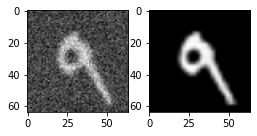

In [0]:
#Visualizing results
pos=7
xin=autoencoder_x[pos]
xin=np.reshape(xin,(1,64,64,1))
yout=autoencoder_y[pos]
ypred=autoencoder.predict(xin)
ypred=np.reshape(ypred,(64,64))
xin=np.reshape(xin,(64,64))

fig=plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(xin,cmap='gray') 
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(ypred,cmap='gray') 


In [0]:
#Creating train and test set to train encoder
train_encoder_path='/content/train_encoder/'
os.mkdir(train_encoder_path) 
for i in range(10):
  class_=train_encoder_path+str(i)+'/'
  os.mkdir(class_)

test_encoder_path='/content/test_encoder/'
os.mkdir(test_encoder_path) 
for i in range(10):
  class_=test_encoder_path+str(i)+'/'
  os.mkdir(class_)     

x_train=data_train.iloc[:,1:]
y_train=data_train.iloc[:,0]

x_test=data_test.iloc[:,1:]
y_test=data_test.iloc[:,0]

for i in range(len(x_train)):
  img=x_train.iloc[i,:]
  img=np.resize(img,(28,28)).astype(np.uint8)
  
  class_= str(y_train[i])
 
  cv2.imwrite(train_encoder_path+class_+'/'+str(i)+'.jpg', img)


for i in range(len(x_test)):
  img=x_test.iloc[i,:]
  img=np.resize(img,(28,28)).astype(np.uint8)

  class_= str(y_test[i])

  cv2.imwrite(test_encoder_path+class_+'/'+str(i)+'.jpg', img)  

In [0]:
#shutil.rmtree('/content/test_noised/') 

In [0]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
batch_size=256
train_flow = train_datagen.flow_from_directory(
    '/content/train_encoder/',
    target_size=(64,64),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle = True,
    seed=0)

test_flow = test_datagen.flow_from_directory(
    '/content/test_encoder/',
    target_size=(64,64),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle = True,
    seed=0)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [0]:
#Encoder
vgg_conv = VGG16(weights='imagenet', include_top=False,input_shape=(64, 64, 3))

for layer in vgg_conv.layers[:]:
    layer.trainable = False
  

model_encoder = models.Sequential()

model_encoder.add(vgg_conv)

model_encoder.add(layers.Flatten())
#model.add(layers.BatchNormalization())
model_encoder.add(layers.Dense(1024, activation='relu'))
model_encoder.add(layers.BatchNormalization())
model_encoder.add(layers.Dropout(0.5))
model_encoder.add(layers.Dense(256, activation='relu'))
model_encoder.add(layers.Dense(10, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model_encoder.summary()     

model_encoder.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_7 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [0]:
history_encoder=model_encoder.fit_generator(
        train_flow,
        steps_per_epoch=60000 // batch_size,
        epochs=50,
        validation_data=test_flow,
        validation_steps=10000 // batch_size)

Epoch 1/50
234/234 [==============================] - 31s 134ms/step - loss: 0.1810 - accuracy: 0.9449 - val_loss: 0.1034 - val_accuracy: 0.9727
Epoch 2/50
234/234 [==============================] - 28s 118ms/step - loss: 0.0860 - accuracy: 0.9731 - val_loss: 0.0792 - val_accuracy: 0.9771
Epoch 3/50
234/234 [==============================] - 28s 118ms/step - loss: 0.0679 - accuracy: 0.9781 - val_loss: 0.0385 - val_accuracy: 0.9784
Epoch 4/50
234/234 [==============================] - 28s 119ms/step - loss: 0.0567 - accuracy: 0.9816 - val_loss: 0.0475 - val_accuracy: 0.9805
Epoch 5/50
234/234 [==============================] - 28s 120ms/step - loss: 0.0496 - accuracy: 0.9836 - val_loss: 0.0781 - val_accuracy: 0.9783
Epoch 6/50
234/234 [==============================] - 28s 120ms/step - loss: 0.0449 - accuracy: 0.9849 - val_loss: 0.0320 - val_accuracy: 0.9786
Epoch 7/50
234/234 [==============================] - 28s 120ms/step - loss: 0.0374 - accuracy: 0.9874 - val_loss: 0.1038 - val_ac

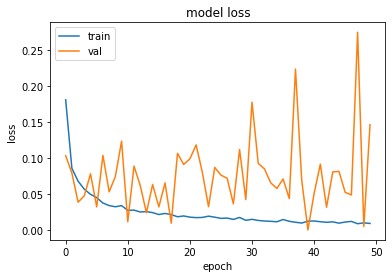

In [0]:
#Plotting Loss Curve
plt.plot(history_encoder.history['loss'])
plt.plot(history_encoder.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

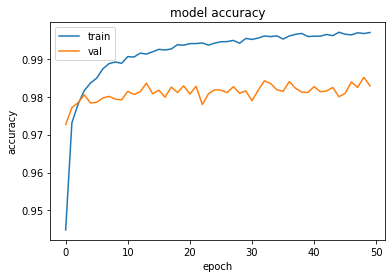

In [0]:
#Plotting Accuracy Curve
plt.plot(history_encoder.history['accuracy'])
plt.plot(history_encoder.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [0]:
def classifier(img):
  img=np.reshape(img,(1,64,64,1))

  img_denoised=autoencoder.predict(img)
  img_denoised=np.reshape(img_denoised,(64,64))

  denoised_rgb = cv2.cvtColor(img_denoised,cv2.COLOR_GRAY2RGB)
  denoised_rgb=np.reshape(denoised_rgb,(1,64,64,3))

  y_pred=model_encoder.predict(denoised_rgb)

  img=np.reshape(img,(64,64))

  fig=plt.figure(figsize=(4,4))
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(img,cmap='gray') 
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(img_denoised,cmap='gray') 

  print('Recognized digit is '+str(y_pred.argmax(axis=-1)))



Recognized digit is [9]


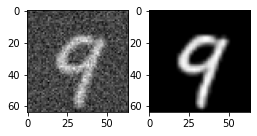

In [0]:
img=autoencoder_x[12]
classifier(img)


Recognized digit is [1]


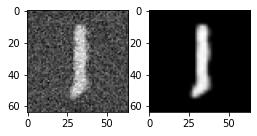

In [0]:
img=autoencoder_x[14]
classifier(img)


Recognized digit is [9]


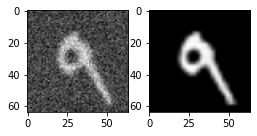

In [0]:
img=autoencoder_x[7]
classifier(img)
